[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://drive.google.com/file/d/1AiLGvFuI-HQuGONH4kIrnjmRJXDCeAXt/view?usp=sharing)

# Example of the remote sensing image classification

The problem: conifer/deciduous forest classification

Raster data: Sentinel 12-band image

Mask: manual region-based markup, including forest dominant species

In [ ]:
! pip install rasterio

In [1]:
import os
import cv2
import sys
import random
import rasterio
import numpy as np
import tifffile as tiff
import matplotlib.image as mpimg
import rasterio 
import matplotlib.pyplot as plt
import pandas as pd

## Download data

In [ ]:
# Get the data, remove temporary
%%capture

! wget http://filebrowser.aeronetlab.space/s/iLtPPSLA8X6IIjR/download -O ./EO_Browser_images_2.zip
! unzip ./EO_Browser_images_2.zip
! rm -f EO_Browser_images_2.zip

In [ ]:
! ls ./EO_Browser_images_2

## Visualize markup for conifer and deciduous

In [4]:
with rasterio.open('EO_Browser_images_2/deciduous.tiff') as src:
    deciduous_mask = src.read(1)
with rasterio.open('EO_Browser_images_2/conifer.tiff') as src:
    conifer_mask = src.read(1)

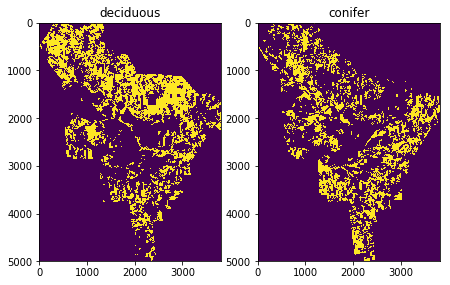

In [5]:
fig = plt.figure(figsize=(15, 15))
    
a = fig.add_subplot(1, 4, 1)
a.set_title('deciduous')
imgplot = plt.imshow(deciduous_mask)

a = fig.add_subplot(1, 4, 2)
a.set_title('conifer')
imgplot = plt.imshow(conifer_mask) 

In [4]:
print('pixels for deciduous:', np.sum(deciduous_mask))
print('pixels for conifer:', np.sum(conifer_mask))

pixels for deciduous: 3358398
pixels for conifer: 2741467


## Visualize markup for 4 classes

In [6]:
with rasterio.open('EO_Browser_images_2/aspen.tiff') as src:
    aspen_mask = src.read(1)
with rasterio.open('EO_Browser_images_2/pine.tiff') as src:
    pine_mask = src.read(1)
with rasterio.open('EO_Browser_images_2/birch.tiff') as src:
    birch_mask = src.read(1)
with rasterio.open('EO_Browser_images_2/spruce.tiff') as src:
    spruce_mask = src.read(1)

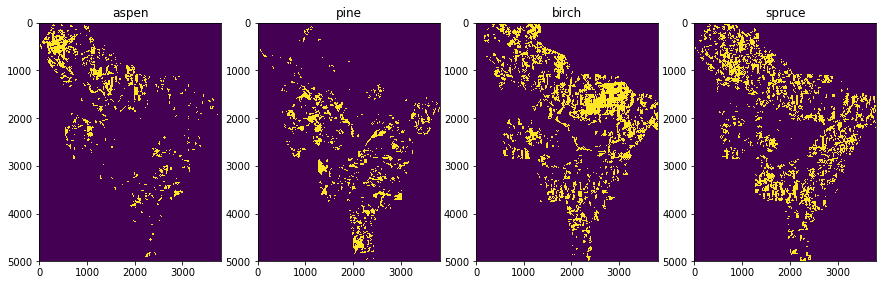

In [7]:
fig = plt.figure(figsize=(15, 15))
    
a = fig.add_subplot(1, 4, 1)
a.set_title('aspen')
imgplot = plt.imshow(aspen_mask)

a = fig.add_subplot(1, 4, 2)
a.set_title('pine')
imgplot = plt.imshow(pine_mask) 

a = fig.add_subplot(1, 4, 3)
a.set_title('birch')
imgplot = plt.imshow(birch_mask)

a = fig.add_subplot(1, 4, 4)
a.set_title('spruce')
imgplot = plt.imshow(spruce_mask)

In [7]:
#check intersection between classes
np.sum(np.where(aspen_mask+pine_mask+birch_mask+spruce_mask>1, 1, 0))

0

## Visualize data

In [8]:
with rasterio.open('EO_Browser_images_2/2019-08-29, Sentinel-2B L1C, B04.tiff') as src:
    r = src.read(1)
with rasterio.open('EO_Browser_images_2/2019-08-29, Sentinel-2B L1C, B03.tiff') as src:
    g = src.read(1)
with rasterio.open('EO_Browser_images_2/2019-08-29, Sentinel-2B L1C, B02.tiff') as src:
    b = src.read(1)

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f37493d2898>)

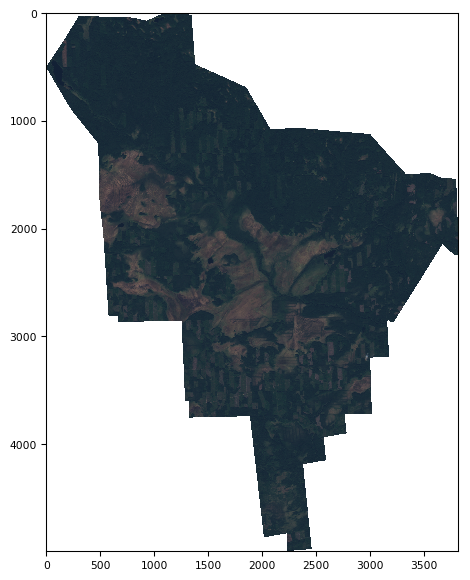

In [9]:
tiff.imshow(np.asarray([r, g, b]))

## Load map of individual forest regions

In [8]:
with rasterio.open('EO_Browser_images_2/ind_map.tiff') as src:
    ind_map = src.read(1)

In [11]:
np.unique(ind_map)

array([      0, 1001001, 1001002, ..., 1187021, 1187022, 1187023],
      dtype=uint32)

In [12]:
# some index
np.unique(ind_map)[len(np.unique(ind_map))//2]

1091005

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f374a678748>)

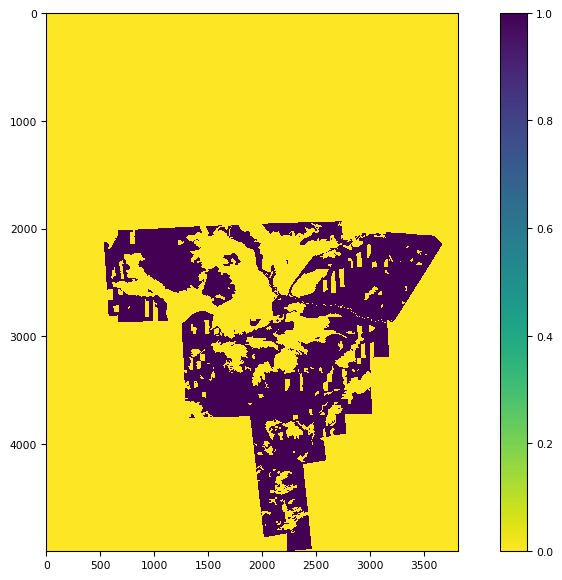

In [13]:
tiff.imshow(np.where(ind_map>np.unique(ind_map)[len(np.unique(ind_map))//2], 1, 0))

In [14]:
print('number of individual regions:', len((np.unique(ind_map))))

number of individual regions: 4898


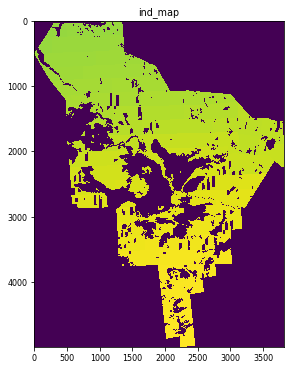

In [15]:
fig = plt.figure(figsize=(6, 6))
    
a = fig.add_subplot(1, 1, 1)
a.set_title('ind_map')
imgplot = plt.imshow(ind_map)

### Count number of individual regions for each class

In [16]:
#delete 0
ind_map = ind_map[1:]

In [17]:
np.unique(ind_map)

array([      0, 1001001, 1001002, ..., 1187021, 1187022, 1187023],
      dtype=uint32)

In [18]:
statistics = {'conifer':0, 'deciduous':0}
for region_id in np.unique(ind_map):
    #the first ocurrence of the particular index
    i, j = np.where(ind_map==region_id)
    statistics['conifer'] += conifer_mask[i[0], j[0]]
    statistics['deciduous'] += deciduous_mask[i[0], j[0]]

In [19]:
print('number of conifer regions: ',statistics['conifer'])
print('number of deciduous regions: ', statistics['deciduous'])

number of conifer regions:  1917
number of deciduous regions:  1967


***

***

# Baseline model 

### Prepare dataset

In [99]:
extract_features(ind_region=1001002)

{'min_01': 16417,
 'max_01': 16564,
 'mean_01': 16522.801136363636,
 'std_01': 42.09749505157959,
 'min_02': 10993,
 'max_02': 12108,
 'mean_02': 11622.289772727272,
 'std_02': 189.5085333529462,
 'min_03': 8405,
 'max_03': 10715,
 'mean_03': 9512.201704545454,
 'std_03': 416.6150347217266,
 'min_04': 4555,
 'max_04': 5505,
 'mean_04': 5029.707386363636,
 'std_04': 182.62875953441176,
 'min_05': 8077,
 'max_05': 11141,
 'mean_05': 9765.244318181818,
 'std_05': 554.1397330256303,
 'min_06': 21987,
 'max_06': 41664,
 'mean_06': 31794.585227272728,
 'std_06': 3409.420535044301,
 'min_07': 27050,
 'max_07': 52608,
 'mean_07': 39727.17897727273,
 'std_07': 4561.529079669632,
 'min_08': 25935,
 'max_08': 54607,
 'mean_08': 39270.318181818184,
 'std_08': 5614.702205220307,
 'min_09': 13156,
 'max_09': 15827,
 'mean_09': 14645.948863636364,
 'std_09': 638.1441911893492,
 'min_10': 98,
 'max_10': 131,
 'mean_10': 127.1278409090909,
 'std_10': 14.577891023805975,
 'min_11': 10699,
 'max_11': 193

In [9]:
# compute features for each individual forest region
from rasterio.windows import Window

MAX_CONST = 65535

def min_val(a): return np.min(a[a>0]) 
def max_val(a): return np.max(a[a<MAX_CONST])
def mean_val(a): return np.mean(a[a>0])
def std_val(a): return np.std(a[a>0])

def extract_features_1(ind_region, window):
    func_list = {'min':min_val, 'max':max_val, 'mean':mean_val, 'std':std_val}
    feature_list = {}
    masked_region = np.where(ind_map == ind_region, 1, 0)[window.col_off:window.col_off+window.width,\
                                                          window.row_off:window.row_off+window.height] 
       
    window = Window(window.row_off, window.col_off, window.height,window.width)
    for band in range(1, 13):
        if band < 10:
            band = '0' + str(band)
        with rasterio.open('EO_Browser_images_2/2019-08-29, Sentinel-2B L1C, B{}.tiff'.format(band)) as src:    
            #2019-06-23
            tmp_img = src.read(1, window=window)
            
        region_of_interest = tmp_img * masked_region * np.where(tmp_img==MAX_CONST, 0, 1)
        for func in func_list.keys():
            feature_list[func+'_'+str(band)] = func_list[func](region_of_interest)

    return feature_list

In [10]:
def extract_features_2():
    func_list = {'min':min_val, 'max':max_val, 'mean':mean_val, 'std':std_val}
    
    X_train = {}
    Y_train = {}
        
    for band in range(1, 13):
        if band < 10:
            band = '0' + str(band)
        with rasterio.open('EO_Browser_images_2/2019-08-29, Sentinel-2B L1C, B{}.tiff'.format(band)) as src:    
            #2019-06-23
            tmp_img = src.read(1)[:-1,:]
        
        for k, ind_region in enumerate(np.unique(ind_map)):
            masked_region = np.where(ind_map == ind_region, 1, 0)
            i, j = np.where(ind_map==ind_region)
            if conifer_mask[i[0], j[0]] + deciduous_mask[i[0], j[0]] == 0:
                continue #there are not classes of our interest
            if np.max(i)-np.min(i)<3 and np.max(j)-np.min(j)<3:
                continue #region is too small, lets skip it
            if ind_region not in X_train.keys():
                X_train[ind_region] = []
                Y_train[ind_region] = [conifer_mask[i[0], j[0]]]
            #print(masked_region.shape, tmp_img.shape)   
            region_of_interest = tmp_img * masked_region * np.where(tmp_img==MAX_CONST, 0, 1)
            feature_list = {}
            for func in func_list.keys():
                feature_list[func+'_'+str(band)] = func_list[func](region_of_interest)
            X_train[ind_region] += [feature_list]

    return X_train, Y_train 

In [11]:
def extract_features_3(ind_region, window):
    func_list = {'min':min_val, 'max':max_val, 'mean':mean_val, 'std':std_val}
    feature_list = {}
    masked_region = np.where(ind_map == ind_region, 1, 0)[window.col_off:window.col_off+window.width,\
                                                          window.row_off:window.row_off+window.height] 
       
    window = Window(window.row_off, window.col_off, window.height,window.width)
    for band in range(1, 13):
        if band < 10:
            band = '0' + str(band)
        with rasterio.open('EO_Browser_images_2/2019-08-29, Sentinel-2B L1C, B{}.tiff'.format(band)) as src:    
            #2019-06-23
            tmp_img = src.read(1, window=window)
            
        region_of_interest = tmp_img * masked_region * np.where(tmp_img==MAX_CONST, 0, 1)
        for func in func_list.keys():
            feature_list[func+'_'+str(band)+'_summer'] = func_list[func](region_of_interest)
            
        with rasterio.open('EO_Browser_images_1/2019-04-21, Sentinel-2B L1C, B{}.tiff'.format(band)) as src:    
            #2019-06-23
            tmp_img = src.read(1, window=window)
            
        region_of_interest = tmp_img * masked_region * np.where(tmp_img==MAX_CONST, 0, 1)
        for func in func_list.keys():
            feature_list[func+'_'+str(band)+'_winter'] = func_list[func](region_of_interest)

    return feature_list

In [ ]:
X_train = []
Y_train = []
for k, ind_region in enumerate(np.unique(ind_map)):
    i, j = np.where(ind_map==ind_region)
    if conifer_mask[i[0], j[0]] + deciduous_mask[i[0], j[0]] == 0:
        continue #there are not classes of our interest
    window = Window(np.min(i), np.min(j), np.max(i)-np.min(i), np.max(j)-np.min(j))
    if np.max(i)-np.min(i)<3 and np.max(j)-np.min(j)<3:
        continue #region is too small, lets skip it
    Y_train += [conifer_mask[i[0], j[0]]]
    X_train += [extract_features_1(ind_region=ind_region, window=window)]
    if k % 100 == 0:
        print(k, len(np.unique(ind_map))) #just to monitor the process

In [13]:
X_df = pd.DataFrame(X_train) 

In [14]:
len(X_train), len(Y_train)

(4477, 4477)

In [15]:
X_df['y'] = Y_train

In [16]:
from random import seed

In [17]:
seed(111)
X_df = X_df.sample(frac=1)

In [18]:
len(X_train)

4477

In [19]:
#splite into train and test
X_train_df = X_df[:3400]
X_test_df = X_df[3400:]

In [20]:
y_train_df = X_train_df["y"]
X_train_df.drop(labels="y", axis=1, inplace=True)

y_test_df = X_test_df["y"]
X_test_df.drop(labels="y", axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [27]:
X_train_df.columns

Index(['min_01', 'max_01', 'mean_01', 'std_01', 'min_02', 'max_02', 'mean_02',
       'std_02', 'min_03', 'max_03', 'mean_03', 'std_03', 'min_04', 'max_04',
       'mean_04', 'std_04', 'min_05', 'max_05', 'mean_05', 'std_05', 'min_06',
       'max_06', 'mean_06', 'std_06', 'min_07', 'max_07', 'mean_07', 'std_07',
       'min_08', 'max_08', 'mean_08', 'std_08', 'min_09', 'max_09', 'mean_09',
       'std_09', 'min_10', 'max_10', 'mean_10', 'std_10', 'min_11', 'max_11',
       'mean_11', 'std_11', 'min_12', 'max_12', 'mean_12', 'std_12'],
      dtype='object')

### Train model

In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [22]:
state = 12  
test_size = 0.3  
  
_X_train, X_val, _y_train, y_val = train_test_split(X_train_df, y_train_df, test_size=test_size, random_state=state)

In [25]:
gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)
gb_clf2.fit(_X_train, _y_train)
predictions = gb_clf2.predict(X_val)

print("Confusion Matrix:")
print(confusion_matrix(y_val, predictions))

print("Classification Report")
print(classification_report(y_val, predictions))

Confusion Matrix:
[[388  90]
 [ 85 457]]
Classification Report
             precision    recall  f1-score   support

          0       0.82      0.81      0.82       478
          1       0.84      0.84      0.84       542

avg / total       0.83      0.83      0.83      1020



In [39]:
gb_clf2 = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_features=20, max_depth=7, random_state=0)
gb_clf2.fit(_X_train, _y_train)
predictions = gb_clf2.predict(X_val)

print("Confusion Matrix:")
print(confusion_matrix(y_val, predictions))

print("Classification Report")
print(classification_report(y_val, predictions))

Confusion Matrix:
[[402  66]
 [ 76 476]]
Classification Report
             precision    recall  f1-score   support

          0       0.84      0.86      0.85       468
          1       0.88      0.86      0.87       552

avg / total       0.86      0.86      0.86      1020



## Add winter image

In [ ]:
X_train_w = []
Y_train_w = []
for k, ind_region in enumerate(np.unique(ind_map)):
    i, j = np.where(ind_map==ind_region)
    if conifer_mask[i[0], j[0]] + deciduous_mask[i[0], j[0]] == 0:
        continue #there are not classes of our interest
    window = Window(np.min(i), np.min(j), np.max(i)-np.min(i), np.max(j)-np.min(j))
    if np.max(i)-np.min(i)<3 and np.max(j)-np.min(j)<3:
        continue #region is too small, lets skip it
    Y_train_w += [conifer_mask[i[0], j[0]]]
    X_train_w += [extract_features_3(ind_region=ind_region, window=window)]
    if k % 100 == 0:
        print(k, len(np.unique(ind_map))) #just to monitor the process



In [60]:
X_df_w = pd.DataFrame(X_train_w) 
X_df_w['y'] = Y_train_w
seed(111)
X_df_w = X_df_w.sample(frac=1)

#splite into train and test
X_train_df_w = X_df_w[:3400]
X_test_df_w = X_df_w[3400:]

y_train_df_w = X_train_df_w["y"]
X_train_df_w.drop(labels="y", axis=1, inplace=True)

y_test_df_w = X_test_df_w["y"]
X_test_df_w.drop(labels="y", axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [55]:
pca = decomposition.PCA(n_components=30)
pca.fit(X_train_df_w)
X_train_df_w = pca.transform(X_train_df_w)

In [56]:
X_train_df_w

array([[-52031.72036864,  -2385.90794424,  -2261.21646638, ...,
          -570.37824227,   -641.54656588,   -292.61139503],
       [  9541.78398793, -12763.22086565,  -5015.5462103 , ...,
         -1941.54362357,  -2001.05775276,    344.38577773],
       [ -1708.6246985 ,  -4434.19346936,   2237.14281684, ...,
           323.05860909,   -818.01037622,  -1460.27488291],
       ...,
       [  7900.11262295, -11180.99501561,   2410.57200574, ...,
          -838.55780294,    183.43840723,   -198.84682733],
       [  9545.67771992, -38358.50374764, -14965.17099001, ...,
          1360.33400515,   -280.09675674,   1478.71290454],
       [ 69502.24365946,  10268.71280802,   8568.35170515, ...,
           455.41313729,   1250.37895806,    405.97637786]])

In [61]:
state = 12  
test_size = 0.30  
  
_X_train_w, X_val_w, _y_train_w, y_val_w = train_test_split(X_train_df_w, y_train_df, test_size=test_size, random_state=state)

In [62]:
gb_model_2 = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_features=20, max_depth=7, random_state=0)
gb_model_2.fit(_X_train_w, _y_train_w)
predictions = gb_model_2.predict(X_val_w)

print("Confusion Matrix:")
print(confusion_matrix(y_val_w, predictions))

print("Classification Report")
print(classification_report(y_val_w, predictions))

Confusion Matrix:
[[203 265]
 [231 321]]
Classification Report
             precision    recall  f1-score   support

          0       0.47      0.43      0.45       468
          1       0.55      0.58      0.56       552

avg / total       0.51      0.51      0.51      1020



### Visualize results

In [64]:
from xgboost import XGBClassifier
import xgboost as xgb

In [65]:
xgb_clf = XGBClassifier( max_depth = 6, n_estimators=200)
xgb_clf.fit(_X_train, _y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [66]:
score = xgb_clf.score(X_val, y_val)
print(score)

0.8676470588235294


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [246]:
score = xgb_clf.score(X_val, y_val)
print(score)

0.861764705882353


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


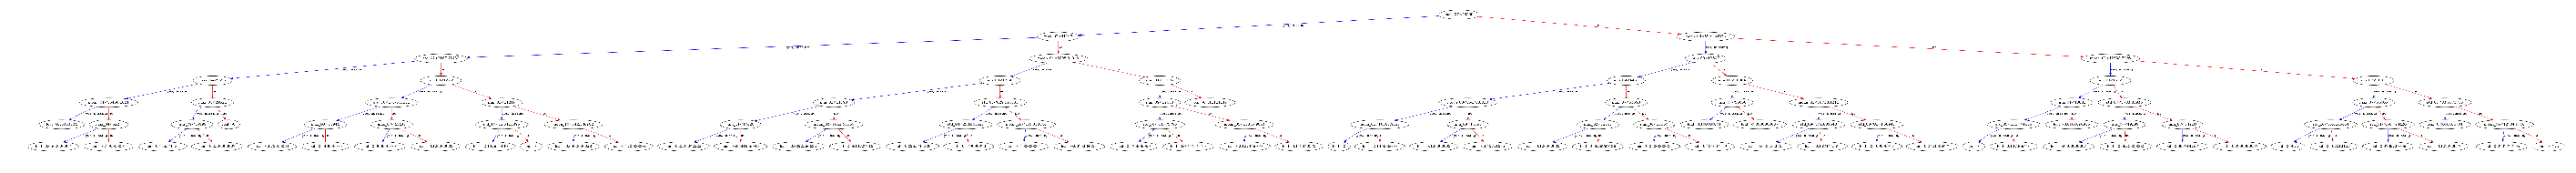

In [222]:
import matplotlib.pyplot as plt

xgb.plot_tree(xgb_clf,num_trees=0)
plt.rcParams['figure.figsize'] = [100, 50]
plt.show()

## New function

In [43]:
from sklearn import decomposition
from sklearn import datasets

pca = decomposition.PCA(n_components=40)
pca.fit(_X_train_w)
X = pca.transform(_X_train_w)

In [42]:
X

array([[ 6.61858980e+03, -1.41025310e+04, -7.18963788e+02, ...,
         2.87729791e+01, -1.79821416e-01,  4.31048118e+01],
       [-1.20462265e+03,  1.24834195e+04,  3.32344342e+02, ...,
        -1.64020900e+02, -7.50035435e+01,  4.98213806e+00],
       [ 9.50840318e+03,  7.37458230e+03,  1.15857816e+04, ...,
        -1.52295087e+00, -5.21661468e+00, -5.60517803e+01],
       ...,
       [-5.65499213e+02,  1.91586369e+03,  8.65717994e+03, ...,
        -8.32255939e+01, -1.89540318e+01,  1.91254082e+01],
       [ 1.65240211e+03, -6.12441491e+03,  9.68710984e+02, ...,
         1.10396531e+02, -7.01675587e+01,  3.96940236e+01],
       [ 4.46489588e+03,  9.58394650e+01,  3.64697931e+03, ...,
        -3.60217614e+01, -4.69738625e+01,  3.75121614e+01]])

## Train Neural Network

In [21]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.layers import Dense, Dropout

from keras.optimizers import RMSprop, Adam, sgd
from tensorflow import set_random_seed
from keras.layers import LeakyReLU
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils import class_weight
import livelossplot
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [22]:
encoder = LabelEncoder()
encoder.fit(y_train_df)
encoded_Y = encoder.transform(y_train_df)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

encoder = LabelEncoder()
encoder.fit(y_test_df)
encoded_Y = encoder.transform(y_test_df)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y)

In [ ]:
from numpy.random import seed
seed(112)
from tensorflow import set_random_seed
set_random_seed(112)

param = {'BATCH_SIZE': 16,
         'dropout': 0.059,
         'layer_1_units': 128,
         'layer_2_units': 16,
         'layer_3_flag': True,
         'layer_3_units': 16,
         'layer_4_units': 32,
         'lr': 0.0001, 
         'opt': 'rmsprop'}

class_weight = {0: 1,
            1: 1,}

model = Sequential()
# Layer 1
model.add(Dense(param['layer_1_units'], input_dim=48)) #, activation='relu'))
model.add(LeakyReLU(alpha=0.0))
model.add(Dropout(param['dropout']))

# Layer 2
model.add(Dense(param['layer_2_units'])) #, activation='relu'))
model.add(LeakyReLU(alpha=0.0)) #0
model.add(Dropout(param['dropout']))

# Layer 3
model.add(Dense(param['layer_3_units'])) #, activation='relu'))
model.add(LeakyReLU(alpha=0.0))
model.add(Dropout(param['dropout']))

if param['layer_3_flag']:
    # Layer 4
    model.add(Dense(param['layer_4_units'])) #, activation='relu'))
    model.add(LeakyReLU(alpha=0.0)) #0
    model.add(Dropout(param['dropout']))

model.add(Dense(2, activation='softmax'))

if param['opt'] == 'Adam':
    model.compile(optimizer=Adam(lr=param['lr']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
elif param['opt'] == 'sgd':
    model.compile(optimizer=sgd(lr=param['lr']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
else:
    model.compile(optimizer=RMSprop(lr=param['lr']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
plot_losses = livelossplot.PlotLossesKeras()

BATCH_SIZE = param['BATCH_SIZE']
EPOCHS = 2000

save_dir = './'

# csv logger
log_filename = os.path.join(save_dir, 'train.csv')
csv_logger = CSVLogger(log_filename, separator=',', append='True')

callbacks=[
    plot_losses,
    #ReduceLROnPlateau(monitor='val_loss',patience=5,min_lr=1e-9,verbose=1,mode='min'),
    ModelCheckpoint( save_dir + 'tmp_model.h5',save_best_only=True,verbose=1,monitor='val_acc', mode='max'),
    ModelCheckpoint(save_dir + 'tmp_weights.hdf5',save_best_only=True,verbose=1, save_weights_only=True,monitor='val_acc', mode='max')
]

model.fit(X_train_df, dummy_y,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks=callbacks,
          verbose=1, #steps_per_epoch=100,
          validation_data=(X_test_df, dummy_y_test)) #, class_weight=class_weight)

model.load_weights(save_dir + 'tmp_weights.hdf5')
score = model.evaluate(X_test_K, dummy_y_test, verbose=0)
print(score)

## Find outliers 

## Add NDVI

## Add more images

## Feature importance

***

***